In [1]:
from typing import (Tuple,List,Dict,Union)
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt

In [2]:
# import torch
# from torch.nn import (Tanh,ReLU)

# def dynamics(y_t:torch.tensor,sigma):
    
#     a,b = y_t
#     y_next = torch.zeros_like(y_t)
    
#     relu = ReLU()

#     y_next[0] =  1.0 * torch.tanh(a) + 0.8 * a * b + 1.0 * b - 1.0 * relu(torch.minimum(a,b)) + sigma * torch.randn(1)
#     y_next[1] = 0.6 * torch.sign(b) + 0.5 * a * b - 1.0 * torch.maximum(a,b) + sigma * torch.randn(1)
    
#     return y_next

# sigma_true = 0.1

# T_total = 2000
# y = torch.zeros((2, T_total))
# y_without_noise = torch.zeros((2, T_total))

# y[:,0] = torch.tensor([0.5,0.5])
# y_without_noise = torch.tensor([0.5,-0.5])

# name_stock = dynamics(y,sigma_true)
# noise = dynamics(y,0)
# # Nomura = name_stock[0]
# # PFN = name_stock[1]
# name_stock[:,0] = torch.tensor([0.5,0.5])
# noise[:,0] = torch.tensor([0.5,-0.5])
# name_stock_label = ["Nomura", "PFN"]


# plt.xlim([T_total-100,T_total])
# plt.plot(name_stock[0].numpy(), color = "#cc0000", label = name_stock_label[0])
# plt.plot(name_stock[1].numpy(), color = "#083090", label = name_stock_label[1])
# plt.plot(noise[0].numpy(), color = "#cc0000", linestyle = "--", label = name_stock_label[0] + "(w/o noise)")
# plt.plot(noise[1].numpy(), color = "#083090", linestyle = "--", label = name_stock_label[1] + "(w/o noise)")
# plt.xlabel("time", fontsize = 18)
# plt.ylabel("y", fontsize = 18)
# plt.legend()

In [55]:
def ReLU(x:np.ndarray)->np.ndarray:

    return np.where(x > 0,x,0)

def sign(x:np.ndarray)->np.ndarray:

    return np.where(x>0,1,0)

def dynamics(y_t:np.ndarray,sigma:float)->np.ndarray:

    a,b = y_t
    size = y.shape[1]
    y_next = np.zeros_like(y_t)

    y_next[0] = 1. * np.tanh(a) + 0.8 * np.multiply(a,b) + 1. * b - 1.* ReLU(np.minimum(a,b))  + sigma*np.random.randn(size)
    y_next[1] = 0.6*sign(b) + 0.5 * np.multiply(a,b) - 1.0 * np.maximum(a, b) + sigma * np.random.randn(size)

    return y_next

In [69]:
T_total = 2000
sigma_true = 0.1

y = np.zeros((2, T_total))

name_stock_label = ["Nomura", "PFN"]

name_stock = dynamics(y,sigma_true)
noise = dynamics(name_stock,0)

name_stock[:,0] = np.array([0.5,0.5])

Nomura = name_stock[0]
PFN = name_stock[1]

noise[:,0] = np.array([0.5,-0.5])


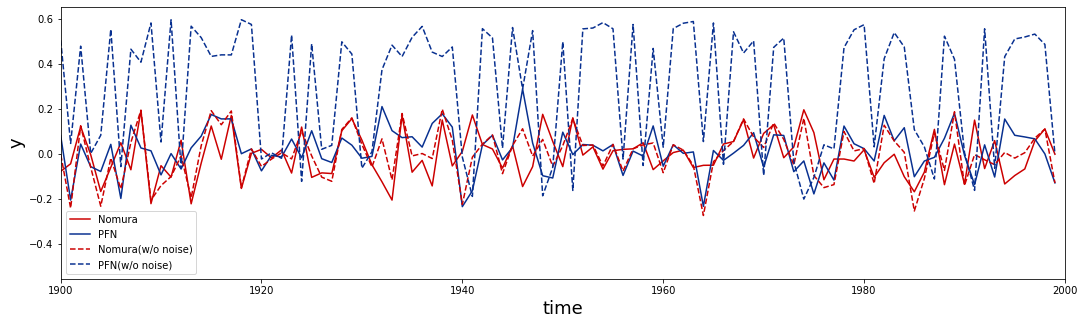

In [74]:
plt.figure(figsize=(18,5))
plt.xlim([T_total-100,T_total])
plt.plot(Nomura, color = "#cc0000", label = name_stock_label[0])
plt.plot(PFN, color = "#083090", label = name_stock_label[1])
plt.plot(noise[0], color = "#cc0000", ls = "--", label = name_stock_label[0] + "(w/o noise)")
plt.plot(noise[1], color = "#083090", ls = "--", label = name_stock_label[1] + "(w/o noise)")
plt.xlabel("time", fontsize = 18)
plt.ylabel("y", fontsize = 18)
plt.legend();